In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

In [2]:
covid_confirmed_df_raw = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')
covid_deaths_df_raw = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_deaths_usafacts.csv')
usa_population_df_raw = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
us_state_vaccinations_df_raw = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')

In [3]:
us_state_abbrev = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AS': 'American Samoa', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO':'Colorado',
    'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District of Columbia', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii',
    'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine',
    'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York State', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'MP': 'Northern Mariana Islands', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VI': 'Virgin Islands', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming' 
}

In [4]:
'''Cleaning the data'''
covid_confirmed_df = covid_confirmed_df_raw [covid_confirmed_df_raw['countyFIPS']>0]
covid_deaths_df = covid_deaths_df_raw [covid_deaths_df_raw['countyFIPS']>0]
usa_population_df = usa_population_df_raw [usa_population_df_raw['population']>0]
us_state_vaccinations_df = us_state_vaccinations_df_raw.fillna(axis=0, method='ffill') # handling empty slots by filling previous day data

'''Retaining some lists that are useful in further questions'''
union_territories = ['American Samoa', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands', 'Republic of Palau', 'Federated States of Micronesia', 'Marshall Islands']

usa_population_usefacts_df = usa_population_df.copy()
usa_population_usefacts_df['state_abbrev'] = usa_population_usefacts_df['State'].map(us_state_abbrev)
us_states = usa_population_usefacts_df['state_abbrev'].unique()
usa_population_df = usa_population_usefacts_df.copy()

special_group = us_state_vaccinations_df[~us_state_vaccinations_df['location'].isin(union_territories)]
special_group = special_group[~special_group['location'].isin(us_states)]
special_group = special_group[special_group['location']!='United States']
special_group = special_group['location'].unique()

dc = 'District of Columbia'

us_states = np.delete(us_states, np.where(us_states==dc))

In [5]:
def get_weekly_data(dataframe, first_sunday):
    weekly_counts = dataframe.loc[:,first_sunday::7]
    weekly_counts.columns = pd.to_datetime(weekly_counts.columns) #to change datatype of dates from string to datetime
    weekly_counts.columns = weekly_counts.columns.strftime('%Y/%m/%d')
    return weekly_counts

In [6]:
def get_people_immune():
    first_sunday = '2020-01-26'
    covid_cases_df = get_weekly_data(covid_confirmed_df, first_sunday)
    covid_death_df = get_weekly_data(covid_deaths_df, first_sunday)
    people_immune = covid_cases_df - covid_death_df
    return people_immune

In [7]:
def get_vaccination_data_for_states(dataframe):
    vacc_value_df = dataframe[dataframe['location']!='United States']
    vacc_value_df = vacc_value_df[~vacc_value_df['location'].isin(special_group)]
    vacc_value_df = vacc_value_df[~vacc_value_df['location'].isin(union_territories)]
    return vacc_value_df

In [8]:
def plot(dataframe):
    plt.figure(figsize=(20,8))
    plt.xticks(rotation=70)
    sns.lineplot(data=dataframe)

# Q2.The vaccination data is reported by the entire county, state, US territory, and various groups like the department of defense, long term care and others. Presumably the US data includes the state data and the special group data but not the US territory data. Is the US territory data included in the US totals. Justify your answer.

In [9]:
us_state_vaccinations_total_df = us_state_vaccinations_df.groupby(['location']).tail(1)

united_states_count_df = us_state_vaccinations_total_df[us_state_vaccinations_total_df['location']=='United States']

only_states_df = get_vaccination_data_for_states(us_state_vaccinations_total_df)

only_ut = us_state_vaccinations_total_df[us_state_vaccinations_total_df['location'].isin(union_territories)]
only_sg = us_state_vaccinations_total_df[us_state_vaccinations_total_df['location'].isin(special_group)]

total_vaccinations_usa_states = only_states_df['total_distributed'].sum()
us_totals = united_states_count_df['total_distributed'].to_string(index=False)

print("Total Vaccination distributed over all states in USA including District of Columbia: {}".format(total_vaccinations_usa_states))
print("Total Vaccination distributed value for us_totals or location mentioned as United States in vaccination data: {}".format(us_totals))

Total Vaccination distributed over all states in USA including District of Columbia: 178431875.0
Total Vaccination distributed value for us_totals or location mentioned as United States in vaccination data:  180644125.0


In [10]:
# state data with union territory data including DC
states_with_ut_and_dc = only_ut['total_distributed'].sum()+total_vaccinations_usa_states
states_with_ut_and_dc

180644125.0

In [11]:
# state data with special group data including DC
states_with_sg_and_dc = only_sg['total_distributed'].sum()+total_vaccinations_usa_states
states_with_sg_and_dc

191469725.0

In [12]:
only_states_df = only_states_df[only_states_df['location']!=dc]
total_vaccinations_usa_states = only_states_df['total_distributed'].sum()

# state data with union territory data excluding DC
states_with_ut_without_dc = only_ut['total_distributed'].sum()+total_vaccinations_usa_states
states_with_ut_without_dc

180152490.0

In [13]:
# state data with special group data excluding DC
states_with_sg_without_dc = only_sg['total_distributed'].sum()+total_vaccinations_usa_states
states_with_sg_without_dc

190978090.0

Checking "total_distributed" column as it says that it is cumulative counts of COVID-19 vaccine doses recorded as shipped in CDC's Vaccine Tracking System.

According to certain combinations tried above, we can conclude that us_totals include count of vaccinations of all different states including "District of Columbia" and union territories, but it does not include any special group count.

# Q3.We would like to compute the percent of the population in each state that has been fully vaccinated. Presumably the data reported got the various groups is not included in the individual state data. If we distributed the number of people fully vaccinated in those groups to the states proportionally by population how much would that change the percent of people vaccinated in each state?

In [14]:
statewise_population_usa = usa_population_df.groupby(['state_abbrev']).sum(['population']).drop(['countyFIPS'], axis=1).reset_index()

us_state_vaccinations_total = us_state_vaccinations_df.groupby(['location']).tail(1)
only_states_vacc_df = get_vaccination_data_for_states(us_state_vaccinations_total)
only_states_vacc_df = only_states_vacc_df[only_states_vacc_df['location']!=dc]

special_group_vacc_df = us_state_vaccinations_df[us_state_vaccinations_df['location'].isin(special_group)]
special_group_vacc_df = special_group_vacc_df.groupby(['location']).tail(1)

ppl_fully_vacc_spc_group = special_group_vacc_df['people_fully_vaccinated'].sum()

total_population_usa = statewise_population_usa['population'].sum()

statewise_pop_vacc_df = pd.merge(only_states_vacc_df, statewise_population_usa, left_on='location', right_on='state_abbrev', how='inner')

Q3_final_df = statewise_pop_vacc_df[['date','location','people_fully_vaccinated','people_fully_vaccinated_per_hundred','population']]
Q3_final_df_copy = Q3_final_df.copy()
Q3_final_df_copy['change'] = (Q3_final_df_copy.loc[:,'population'].div(total_population_usa)).mul(ppl_fully_vacc_spc_group)
Q3_final_df_copy['new_ppl_vacc_per_100'] = ((Q3_final_df_copy.loc[:,'change']+Q3_final_df_copy.loc[:,'people_fully_vaccinated']).div(Q3_final_df_copy.loc[:,'population'])).mul(100)
Q3_final_df_copy['%change'] = Q3_final_df_copy['new_ppl_vacc_per_100'] - Q3_final_df_copy['people_fully_vaccinated_per_hundred']
Q3_final_df = Q3_final_df_copy

display(Q3_final_df)

date        location  people_fully_vaccinated  \
0   2021-03-27         Alabama                 623385.0   
1   2021-03-27          Alaska                 156698.0   
2   2021-03-27         Arizona                1154039.0   
3   2021-03-27        Arkansas                 388657.0   
4   2021-03-27      California                5830902.0   
5   2021-03-27        Colorado                 946188.0   
6   2021-03-27     Connecticut                 664680.0   
7   2021-03-27        Delaware                 146193.0   
8   2021-03-27         Florida                3160502.0   
9   2021-03-27         Georgia                1250189.0   
10  2021-03-27          Hawaii                 250944.0   
11  2021-03-27           Idaho                 274190.0   
12  2021-03-27        Illinois                1945476.0   
13  2021-03-27         Indiana                1060159.0   
14  2021-03-27            Iowa                 562423.0   
15  2021-03-27          Kansas                 452500.0   
16  2021-03-27        Kentucky                 707589.0   
17  2021-03-27       Louisiana                 696039.0   
18  2021-03-27           Maine                 247671.0   
19  2021-03-27        Maryland                 943997.0   
20  2021-03-27   Massachusetts                1196939.0   
21  2021-03-27        Michigan                1561981.0   
22  2021-03-27       Minnesota                 960958.0   
23  2021-03-27     Mississippi                 413621.0   
24  2021-03-27        Missouri                 836598.0   
25  2021-03-27         Montana                 186055.0   
26  2021-03-27        Nebraska                 319276.0   
27  2021-03-27          Nevada                 458957.0   
28  2021-03-27   New Hampshire                 219594.0   
29  2021-03-27      New Jersey                1491691.0   
30  2021-03-27      New Mexico                 462221.0   
31  2021-03-27  New York State                2846185.0   
32  2021-03-27  North Carolina                1604103.0   
33  2021-03-27    North Dakota                 144728.0   
34  2021-03-27            Ohio                1824671.0   
35  2021-03-27        Oklahoma                 652623.0   
36  2021-03-27          Oregon                 648511.0   
37  2021-03-27    Pennsylvania                1954462.0   
38  2021-03-27    Rhode Island                 198769.0   
39  2021-03-27  South Carolina                 718292.0   
40  2021-03-27    South Dakota                 185598.0   
41  2021-03-27       Tennessee                 862669.0   
42  2021-03-27           Texas                3577806.0   
43  2021-03-27            Utah                 349599.0   
44  2021-03-27         Vermont                 105283.0   
45  2021-03-27        Virginia                1324177.0   
46  2021-03-27      Washington                1235085.0   
47  2021-03-27   West Virginia                 327909.0   
48  2021-03-27       Wisconsin                1007687.0   
49  2021-03-27         Wyoming                  96104.0   

    people_fully_vaccinated_per_hundred  population         change  \
0                                 12.71     4903185   38599.029627   
1                                 21.42      731545    5758.894908   
2                                 15.85     7278717   57299.778232   
3                                 12.88     3017804   23756.865386   
4                                 14.76    39512223  311049.545595   
5                                 16.43     5758736   45334.129036   
6                                 18.64     3565287   28066.780785   
7                                 15.01      973764    7665.700047   
8                                 14.72    21477737  169077.815092   
9                                 11.77    10617423   83582.859905   
10                                17.72     1415872   11146.078575   
11                                15.34     1787065   14068.197484   
12                                15.35    12671821   99755.565864   
13                  

# Q4. Produce a chart or table showing the percent of people in each state that have been fully vaccinated. Sort the data by the percent of people vaccinated. You notebook should download the dataset so when it is run we get the most recent data.

In [15]:
us_pop_vacc_df = statewise_pop_vacc_df[['location','people_fully_vaccinated_per_hundred']]
us_pop_vacc_df = us_pop_vacc_df.rename(columns={'people_fully_vaccinated_per_hundred':'%_people_vaccinated'})
us_pop_vacc_df = us_pop_vacc_df[['location','%_people_vaccinated']].set_index('location').sort_values(by=['%_people_vaccinated'], ascending=False)

display(us_pop_vacc_df)

%_people_vaccinated
location                           
New Mexico                    22.04
Alaska                        21.42
South Dakota                  20.98
North Dakota                  18.99
Rhode Island                  18.76
Connecticut                   18.64
Maine                         18.42
West Virginia                 18.30
Iowa                          17.83
Hawaii                        17.72
Montana                       17.41
Massachusetts                 17.37
Wisconsin                     17.31
Minnesota                     17.04
Vermont                       16.87
New Jersey                    16.79
Wyoming                       16.61
Nebraska                      16.51
Oklahoma                      16.49
Colorado                      16.43
Washington                    16.22
New Hampshire                 16.15
Arizona                       15.85
Kentucky                      15.84
Indiana                       15.75
Michigan                      15.64
Maryland                      15.61
Ohio                          15.61
Kansas                        15.53
Virginia                      15.51
Oregon                        15.38
Illinois                      15.35
Idaho                         15.34
North Carolina                15.29
Pennsylvania                  15.27
Delaware                      15.01
Louisiana                     14.97
Nevada                        14.90
California                    14.76
Florida                       14.72
New York State                14.63
South Carolina                13.95
Mississippi                   13.90
Missouri                      13.63
Arkansas                      12.88
Alabama                       12.71
Tennessee                     12.63
Texas                         12.34
Georgia                       11.77
Utah                          10.90

# Q5.We want to see the progression from the start of the pandemic to now the percent of people that have some immunity in the US. Produce a plot of weekly data that contains three lines. One showing the the percent of the living people have have or had covid. One showing the the percent of people that have had at least one covid vaccine shot. The third line showing the sum of the two to estimate the number of people that have some immunity. Over time sum will be an over estimate as people who had covid get a vaccine shot. As in #4 the notebook should download the data to up-to-date results.

%_people_immune_recovered  %_people_vaccinated  %_total_immunity
week                                                                        
2020/01/26                   0.000002             0.000000          0.000002
2020/02/02                   0.000003             0.000000          0.000003
2020/02/09                   0.000003             0.000000          0.000003
2020/02/16                   0.000004             0.000000          0.000004
2020/02/23                   0.000005             0.000000          0.000005
...                               ...                  ...               ...
2021/02/21                   8.239248            13.108650         21.347898
2021/02/28                   8.374245            14.910801         23.285046
2021/03/07                   8.491475            17.651620         26.143095
2021/03/14                   8.601654            20.916259         29.517913
2021/03/21                   8.708428            24.405571         33.113998

[61 rows x 3 columns]

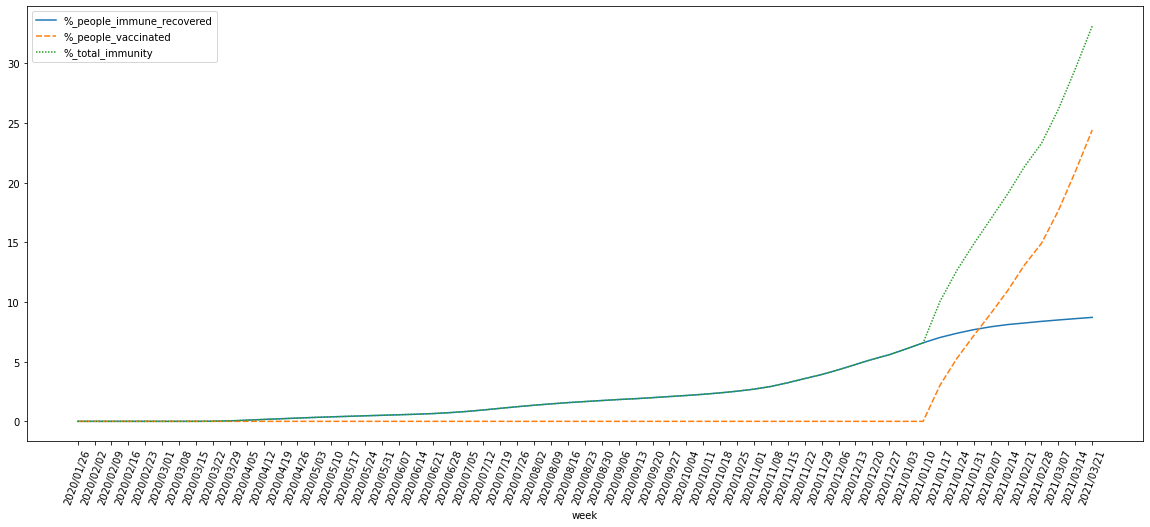

In [16]:
people_immune = get_people_immune()
dates = people_immune.columns

vacc_value_df = get_vaccination_data_for_states(us_state_vaccinations_df)

vacc_value_df = vacc_value_df.groupby(['date']).sum('people_vaccinated').reset_index()
vacc_value_df = vacc_value_df[['date','people_vaccinated']]
vacc_value_df = vacc_value_df.set_index('date').transpose()

first_sunday = '2021-01-17'
vacc_value_df = get_weekly_data(vacc_value_df, first_sunday)
vacc_value_df = vacc_value_df.transpose()

total_people_immune = people_immune.sum().to_frame().rename_axis("week").reset_index()
total_people_immune = total_people_immune.rename(columns={0:"people_immune"})

vacc_value_df = vacc_value_df.reindex(dates, fill_value=0).rename_axis("week").reset_index()

covid_immunity_df = total_people_immune.merge(vacc_value_df, on='week')
covid_immunity_df['sum_immune'] = covid_immunity_df['people_immune'] + covid_immunity_df['people_vaccinated']
covid_immunity_df = covid_immunity_df.set_index('week')
covid_immunity_df_copy = covid_immunity_df.copy()
covid_immunity_df = (covid_immunity_df_copy.div(total_population_usa)).mul(100)
covid_immunity_df = covid_immunity_df.rename(columns={"people_immune":"%_people_immune_recovered", "people_vaccinated":"%_people_vaccinated","sum_immune":"%_total_immunity"})

display(covid_immunity_df)
plot(covid_immunity_df)

# Q6. Produce the same plot as in #5 for the states. You should have a function that takes the two letter abbreviation for the state and produces the plot for the state.

In [17]:
def statewise_immunity_plot_state(state_abbrev, vacc_value_df):
    first_sunday = '2021-01-17'
    state = us_state_abbrev[state_abbrev]
    state_population = statewise_pop_vacc_df[statewise_pop_vacc_df['location']==state].population.sum() #To reatin population of required state

    vacc_value_df = vacc_value_df[vacc_value_df['location']==state].set_index('date')
    vacc_value_df = vacc_value_df[['people_vaccinated']].transpose()
    vacc_value_df = get_weekly_data(vacc_value_df, first_sunday)
    vacc_value_df = vacc_value_df.transpose().reindex(dates, fill_value=0).reset_index()
    vacc_value_df = vacc_value_df.rename(columns={'index':"week"})

    people_immune = get_people_immune()
    states = covid_confirmed_df[['State']]
    people_immune['State'] = states['State']
    people_immune = people_immune.groupby(['State']).sum()
    people_immune = people_immune.loc[state_abbrev,:].transpose().reset_index()
    people_immune = people_immune.rename(columns={'index':'week', state_abbrev:'people_immune_to_covid'})

    covid_immunity_df_state = people_immune.merge(vacc_value_df, on='week')
    covid_immunity_df_state['sum_immunity'] = covid_immunity_df_state['people_vaccinated'] + covid_immunity_df_state['people_immune_to_covid']
    covid_immunity_df_state = covid_immunity_df_state.set_index('week')
    covid_immunity_df_copy = covid_immunity_df_state.copy()
    covid_immunity_df_state = (covid_immunity_df_copy.div(state_population)).mul(100)
    covid_immunity_df_state = covid_immunity_df_state.rename(columns={"people_immune_to_covid":"%_people_immune", "people_vaccinated":"%_people_vaccinated","sum_immunity":"%_total_immunity"})
    display(covid_immunity_df_state)
    plot(covid_immunity_df_state)

In [18]:
def statewise_immunity_plot(state_abbrev):
    vacc_value_df = get_vaccination_data_for_states(us_state_vaccinations_df)
    statewise_immunity_plot_state(state_abbrev, vacc_value_df)

%_people_immune  %_people_vaccinated  %_total_immunity
week                                                              
2020/01/26         0.000000             0.000000          0.000000
2020/02/02         0.000000             0.000000          0.000000
2020/02/09         0.000000             0.000000          0.000000
2020/02/16         0.000000             0.000000          0.000000
2020/02/23         0.000000             0.000000          0.000000
...                     ...                  ...               ...
2021/02/21        11.329219            11.115897         22.445116
2021/02/28        11.468740            12.222587         23.691327
2021/03/07        11.568523            15.050447         26.618970
2021/03/14        11.659323            19.073144         30.732467
2021/03/21        11.767372            21.711607         33.478979

[61 rows x 3 columns]

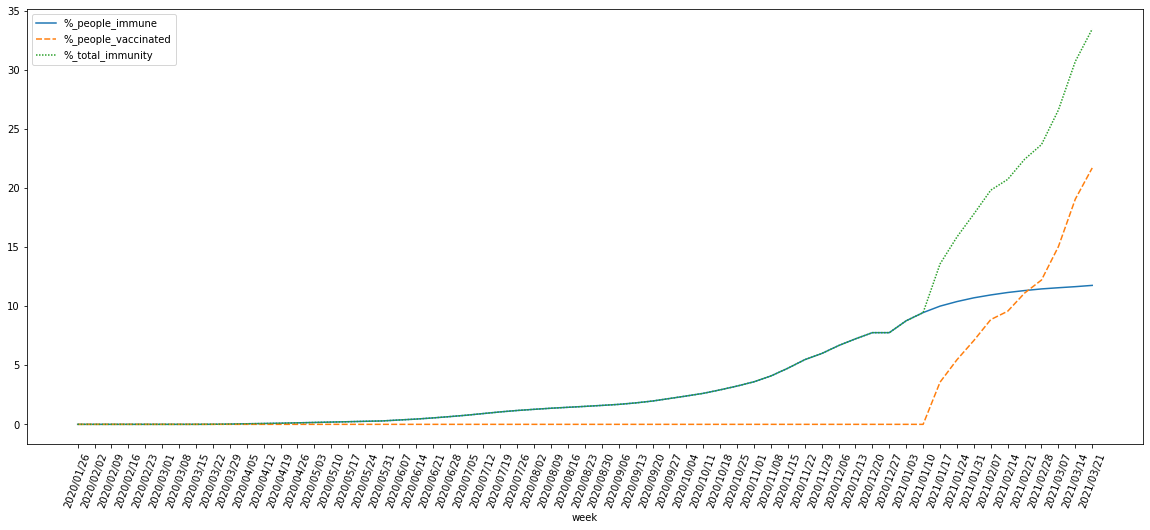

In [19]:
statewise_immunity_plot('UT')

# Q1.In us_state_vaccinations.csv there are some gaps in the data. Will those gaps affect the results of the following questions. If no why not. If yes explain the affect.

Gaps would have affected if we dropped the location which had null values. 
This effects questions 2 through 4 if sunday date has empty values in it, as we are taking week counts on every sunday's.
For question 5 and 6, it would have affected if present day value is empty.

We could overcome this issue by filling those gaps with previous date's data and this resolved our problem as the data is cumulative.

us_state_vaccinations_df_raw is vaccination dataframe before forward fill.
us_state_vaccinations_df is vaccination dataframe after forward fill.

All the above questions used us_state_vaccinations_df as a vaccination dataframe.

Let's check how us_state_vaccinations_df_raw would have affected the output of Q6 for example,

In [20]:
def statewise_immunity_plot_raw(state_abbrev):
    vacc_value_df = get_vaccination_data_for_states(us_state_vaccinations_df_raw)
    statewise_immunity_plot_state(state_abbrev, vacc_value_df)

%_people_immune  %_people_vaccinated  %_total_immunity
week                                                              
2020/01/26         0.000000             0.000000          0.000000
2020/02/02         0.000000             0.000000          0.000000
2020/02/09         0.000000             0.000000          0.000000
2020/02/16         0.000000             0.000000          0.000000
2020/02/23         0.000000             0.000000          0.000000
...                     ...                  ...               ...
2021/02/21        11.329219            11.115897         22.445116
2021/02/28        11.468740            12.222587         23.691327
2021/03/07        11.568523            15.050447         26.618970
2021/03/14        11.659323            19.073144         30.732467
2021/03/21        11.767372            21.711607         33.478979

[61 rows x 3 columns]

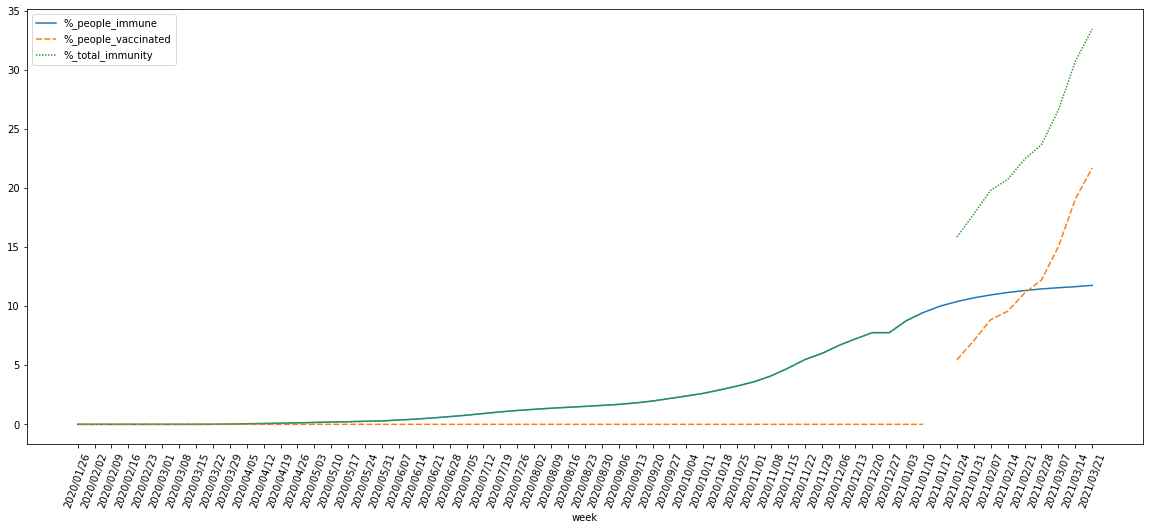

In [21]:
statewise_immunity_plot_raw('UT')